## Exploratory Data Analysis

In [1]:
# import libraries
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division




import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go


In [2]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install chart_studio

In [3]:
#Import Data
parse_dates = ['order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'shipping_limit_date',
'review_creation_date',
 'review_answer_timestamp',]

OL_Data = pd.read_csv("./OL_Data_Order_Grouped.csv", 
                      parse_dates=parse_dates,
                      date_parser = pd.to_datetime)



OL_Data.dtypes


Unnamed: 0                                int64
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
shipping_limit_date              datetime64[ns]
payment_installments                    float64
product_category_name_english            object
seller_id                                object
seller_zip_code_prefix                  float64
seller_city                              object
seller_state                             object
seller_latitude                         float64
seller_longitude                        float64
customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                           

<div class="span5 alert alert-info">
<h2>RFM Scoring</h2>
</div>

<h4>Functions</h4>

In [4]:
from sklearn.cluster import KMeans

def PrintKmeansInertiaGraph(dataFrame, column):
    PrintKmeansInertiaGraphWithArray(dataFrame, [column])
    
def PrintKmeansInertiaGraphWithArray(dataFrame, columns):
    sse={}
    columnDF = dataFrame[columns]
    
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(columnDF)
        columnDF.assign(clusters=kmeans.labels_)
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.show()
    
def PerformKMeans(dataFrame, column, numClusters):
    kmeans = KMeans(n_clusters=numClusters)
    kmeans.fit(dataFrame[[column]])
    clusterCol = '{0}Cluster'.format(column)
    clusters = kmeans.predict(dataFrame[[column]])
    if(clusterCol in dataFrame.columns):
        dataFrame.loc[:,clusterCol] = clusters
    else:
        dataFrame[clusterCol] = clusters
    
def PerformKMeansWithArray(dataFrame, columns, numClusters, clusterName, sub=None):
    kmeans = KMeans(n_clusters=numClusters)
    kmeans.fit(dataFrame[columns])
    clusterCol = '{0}'.format(clusterName)
    clusters = kmeans.predict(dataFrame[columns])
    if sub!=None:
        clusters = [sub+str(x) for x in clusters]
    
    if(clusterCol in dataFrame.columns):
        dataFrame.loc[:,clusterCol] = clusters
    else:
        dataFrame[clusterCol] = clusters
        
    
    
#function for ordering cluster numbers
def clustersInOrder(clusterName, targetName, dataFrame, ascending):
    
    #Set New Labels on Clusters, 0-max in order of mean targetName Value
    df_new = dataFrame.groupby(clusterName)[targetName].mean().reset_index()
    df_new = df_new.sort_values(by=targetName,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    
    #Set New Labels of Clusters to 
    df_final = pd.merge(dataFrame,df_new[[clusterName,'index']], on=clusterName)
    df_final = df_final.drop([clusterName],axis=1)
    df_final = df_final.rename(columns={"index":clusterName})
    
    return df_final

<div class="span5 alert alert-info">
<h3>Buyers</h3>
</div>

<h4>Recency</h4>

count    94467.000000
mean       241.859888
std        152.702590
min          0.000000
25%        118.000000
50%        223.000000
75%        350.000000
max        728.000000
Name: Buyer_Recency, dtype: float64


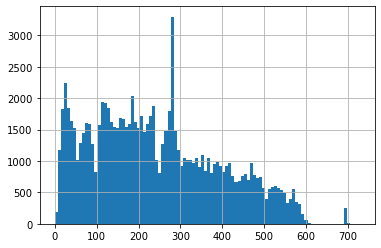

In [5]:
#Recency Score Calc
buyers = pd.DataFrame(OL_Data['customer_unique_id'].unique())
buyers.columns=['CustomerUniqueID']

buyerMaxPurchase = OL_Data.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
buyerMaxPurchase.columns = ['CustomerUniqueID', 'MaxPurchaseDate']

buyerMaxPurchase['Buyer_Recency'] = (buyerMaxPurchase['MaxPurchaseDate'].max() - buyerMaxPurchase['MaxPurchaseDate']).dt.days

buyers = pd.merge(buyers, buyerMaxPurchase[['CustomerUniqueID','Buyer_Recency']])

print(buyers['Buyer_Recency'].describe())
buyers.Buyer_Recency.sort_values().hist(bins=100)
plt.show()


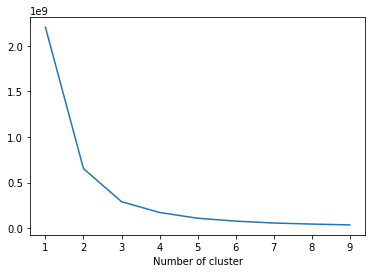

In [6]:
PrintKmeansInertiaGraph(buyers,'Buyer_Recency')

In [7]:
#Generate Recency Clusters, named 'RecencyCluster'
PerformKMeans(buyers,'Buyer_Recency', 4)

#Reset Cluster Names, Lower Recency = More Recent, Higher RecencyCluster
buyers = clustersInOrder('Buyer_RecencyCluster', 'Buyer_Recency', buyers, False)

<h4>Frequency</h4>

count    94467.000000
mean         1.061005
std          0.289504
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: Buyer_Frequency, dtype: float64


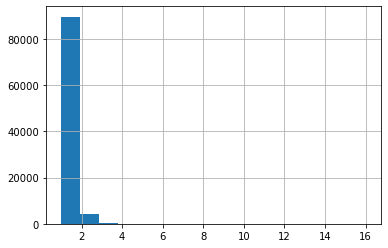

In [8]:
#Frequency
freq = OL_Data.groupby('customer_unique_id').order_id.count().reset_index()
freq.columns = ['CustomerUniqueID','Buyer_Frequency']
freq.head()

buyers = pd.merge(buyers,freq, on='CustomerUniqueID')

print(buyers['Buyer_Frequency'].describe())
buyers.Buyer_Frequency.sort_values().hist(bins=16)
plt.show()

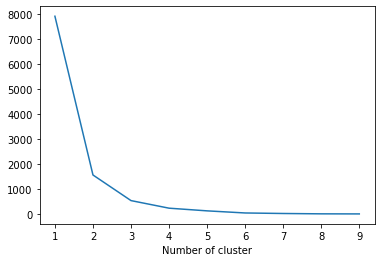

In [9]:
PrintKmeansInertiaGraph(buyers,'Buyer_Frequency')

In [10]:
#Generate Recency Clusters, named 'FrequencyCluster'
PerformKMeans(buyers,'Buyer_Frequency', 4)

#Reset Cluster Names, Higher Frequency = More Frequent, Higher Frequency Cluster
buyers = clustersInOrder('Buyer_FrequencyCluster', 'Buyer_Frequency', buyers, True)

<h4>Revenue</h4>

count    94467.000000
mean       182.890726
std        306.673979
min          0.000000
25%         63.230000
50%        108.840000
75%        188.340000
max      13664.080000
Name: Buyer_Revenue, dtype: float64


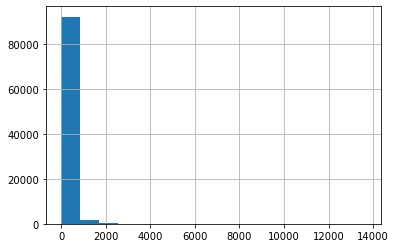

In [11]:
#Revenue
rev = OL_Data.groupby('customer_unique_id').Total_payment.sum().reset_index()
rev.columns = ['CustomerUniqueID','Buyer_Revenue']

buyers = pd.merge(buyers, rev, on='CustomerUniqueID')

print(buyers['Buyer_Revenue'].describe())
buyers.Buyer_Revenue.sort_values().hist(bins=16)
plt.show()

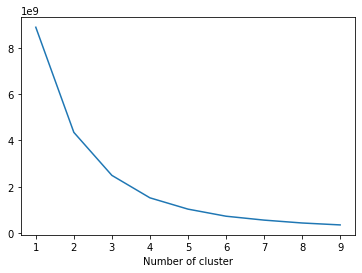

In [12]:
PrintKmeansInertiaGraph(buyers,'Buyer_Revenue')

In [13]:
#Generate Revenue Clusters, named 'RevenueCluster'
PerformKMeans(buyers,'Buyer_Revenue', 5)

#Reset Cluster Names, Higher Revenue, Higher Revenue Cluster
buyers = clustersInOrder('Buyer_RevenueCluster', 'Buyer_Revenue', buyers, True)

<h4>Scale RFM and Cluster</h4>

In [14]:
sub = buyers[['Buyer_Recency','Buyer_Frequency','Buyer_Revenue','CustomerUniqueID']]

sub = sub.assign(scale_recency=sub.apply(lambda x: 1 - x['Buyer_Recency']/sub['Buyer_Recency'].max(),axis=1))
sub = sub.assign(scale_frequency=sub.apply(lambda x: x['Buyer_Frequency']/sub['Buyer_Frequency'].max(),axis=1))
sub = sub.assign(scale_revenue=sub.apply(lambda x: x['Buyer_Revenue']/sub['Buyer_Revenue'].max(),axis=1))

sub = sub.assign(Buyer_Overall_RFM_Scaled =sub.apply(lambda x: x['scale_recency']+x['scale_frequency']+x['scale_revenue'],axis=1))

sub.columns

Index(['Buyer_Recency', 'Buyer_Frequency', 'Buyer_Revenue', 'CustomerUniqueID',
       'scale_recency', 'scale_frequency', 'scale_revenue',
       'Buyer_Overall_RFM_Scaled'],
      dtype='object')

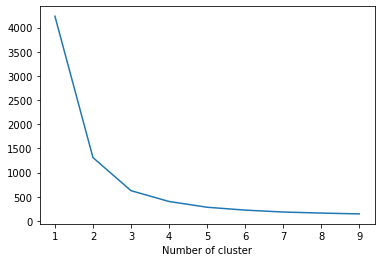

In [15]:
PrintKmeansInertiaGraphWithArray(sub,['scale_recency','scale_frequency','scale_revenue'])

In [16]:
PerformKMeansWithArray(sub, ['scale_recency','scale_frequency','scale_revenue'], 6, 'Buyer_RFM_cluster')

sub.groupby('Buyer_RFM_cluster')[['scale_recency','scale_frequency','scale_revenue']].mean().reset_index()

buyers = buyers.merge(sub[['Buyer_RFM_cluster','CustomerUniqueID','Buyer_Overall_RFM_Scaled']], on='CustomerUniqueID')

In [17]:
print(buyers.columns)
buyers = clustersInOrder('Buyer_RFM_cluster', 'Buyer_Overall_RFM_Scaled', buyers, True)

Index(['CustomerUniqueID', 'Buyer_Recency', 'Buyer_RecencyCluster',
       'Buyer_Frequency', 'Buyer_FrequencyCluster', 'Buyer_Revenue',
       'Buyer_RevenueCluster', 'Buyer_RFM_cluster',
       'Buyer_Overall_RFM_Scaled'],
      dtype='object')


<h4>Alternative RFM Clustering, sum RFM for overall score</h4>

In [18]:
#calculate overall score and use mean() to see details
buyers['Buyer_OverallRFMScore'] = buyers['Buyer_RecencyCluster'] + buyers['Buyer_FrequencyCluster'] + buyers['Buyer_RevenueCluster']
buyers['Buyer_OverallRFM_Raw'] = buyers['Buyer_Recency'] + buyers['Buyer_Frequency'] + buyers['Buyer_Revenue']

print(buyers.groupby('Buyer_OverallRFMScore')[['Buyer_Recency','Buyer_Frequency','Buyer_Revenue']].mean())

print(buyers.groupby('Buyer_OverallRFMScore')[['Buyer_Revenue']].count())

                       Buyer_Recency  Buyer_Frequency  Buyer_Revenue
Buyer_OverallRFMScore                                               
0                         486.923036         1.000000      95.150464
1                         337.757517         1.011264     122.551924
2                         214.366837         1.028837     144.955720
3                          99.892668         1.045681     170.775050
4                         111.861432         1.262510     456.835356
5                         110.617136         1.657879     858.266303
6                         103.844037         2.176147    1413.839211
7                         102.385093         2.782609    2372.684783
8                          97.207547         4.150943    3225.849434
9                          69.083333         4.166667    4316.088333
                       Buyer_Revenue
Buyer_OverallRFMScore               
0                              13318
1                              21750
2                       

In [19]:
#Assign labels
buyers['Buyer_RFM_Ranking'] = '0-Lowest'
buyers.loc[buyers['Buyer_OverallRFMScore']>=1,'Buyer_RFM_Ranking'] ='1-Low' 
buyers.loc[buyers['Buyer_OverallRFMScore']>=3, 'Buyer_RFM_Ranking'] = '2-Medium'
buyers.loc[buyers['Buyer_OverallRFMScore']>=6, 'Buyer_RFM_Ranking'] = '3-High'
buyers.loc[buyers['Buyer_OverallRFMScore']>=8, 'Buyer_RFM_Ranking'] = '4-Highest'

In [20]:
buyers.head()

,CustomerUniqueID,Buyer_Recency,Buyer_RecencyCluster,Buyer_Frequency,Buyer_FrequencyCluster,Buyer_Revenue,Buyer_RevenueCluster,Buyer_Overall_RFM_Scaled,Buyer_RFM_cluster,Buyer_OverallRFMScore,Buyer_OverallRFM_Raw,Buyer_RFM_Ranking
0,7c396fd4830fd04220f754e42b4e5bff,335,1,2,1,82.82,0,0.670896,2,2,419.82,1-Low
1,7973a6ba9c81ecaeb3d628c33c7c7c48,348,1,2,1,115.74,0,0.655448,2,2,465.74,1-Low
2,0a5df23b922b9998bb7378f1ac03c98a,338,1,2,1,193.83,0,0.674900,2,2,533.83,1-Low
3,95cfb39a7e263160308a934e42cfc4e0,287,1,2,1,122.05,0,0.739701,2,2,411.05,1-Low
4,646d643b4ac1184e383341f8896c3dc8,286,1,2,1,178.04,0,0.745173,2,2,466.04,1-Low


<div class="span5 alert alert-info">
<h3>Sellers</h3>
</div>

<h4>Recency</h4>

count    2977.000000
mean      134.126638
std       163.831359
min         0.000000
25%        17.000000
50%        46.000000
75%       210.000000
max       699.000000
Name: Seller_Recency, dtype: float64


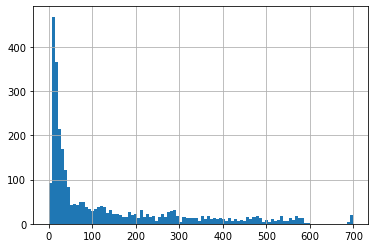

In [21]:
#Recency Score Calc
sellers = pd.DataFrame(OL_Data['seller_id'].unique())
sellers.columns=['SellerID']

sellerMaxSale = OL_Data.groupby('seller_id').order_purchase_timestamp.max().reset_index()
sellerMaxSale.columns = ['SellerID', 'MaxSaleDate']

sellerMaxSale['Seller_Recency'] = (sellerMaxSale['MaxSaleDate'].max() - sellerMaxSale['MaxSaleDate']).dt.days

sellers = pd.merge(sellers, sellerMaxSale[['SellerID','Seller_Recency']])

print(sellers['Seller_Recency'].describe())
sellers.Seller_Recency.sort_values().hist(bins=100)
plt.show()

<h4>Frequency</h4>

count    2977.000000
mean       33.667786
std       108.081772
min         1.000000
25%         2.000000
50%         7.000000
75%        22.000000
max      1865.000000
Name: Seller_Frequency, dtype: float64


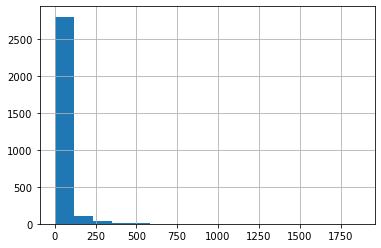

In [22]:
#Frequency
freq = OL_Data.groupby('seller_id').order_id.count().reset_index()
freq.columns = ['SellerID','Seller_Frequency']
freq.head()

sellers = pd.merge(sellers,freq, on='SellerID')

print(sellers['Seller_Frequency'].describe())
sellers.Seller_Frequency.sort_values().hist(bins=16)
plt.show()

<h4>Revenue</h4>

count      2977.000000
mean       5803.513779
std       17929.475314
min          15.220000
25%         315.440000
50%        1164.380000
75%        4533.870000
max      301542.650000
Name: Seller_Revenue, dtype: float64


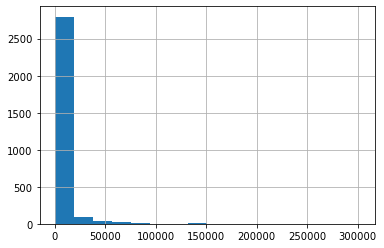

In [23]:
#Revenue
rev = OL_Data.groupby('seller_id').Total_payment.sum().reset_index()
rev.columns = ['SellerID','Seller_Revenue']

sellers = pd.merge(sellers, rev, on='SellerID')

print(sellers['Seller_Revenue'].describe())
sellers.Seller_Revenue.sort_values().hist(bins=16)
plt.show()

Seller_Recency


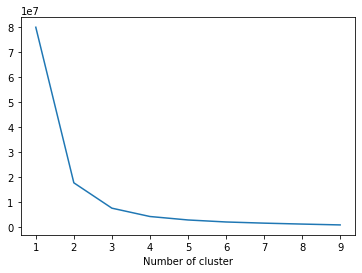


Seller_Frequency


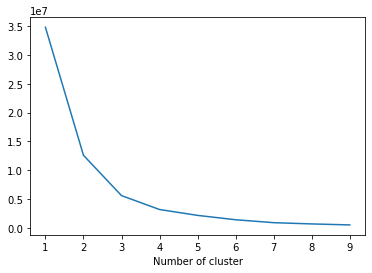


Seller_Revenue


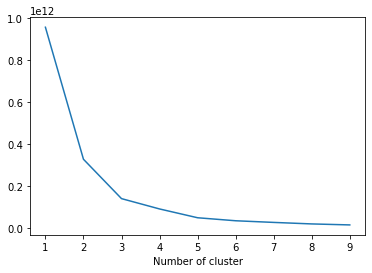

In [24]:
print('Seller_Recency')
PrintKmeansInertiaGraph(sellers,'Seller_Recency')
print('')
print('Seller_Frequency')
PrintKmeansInertiaGraph(sellers,'Seller_Frequency')
print('')
print('Seller_Revenue')
PrintKmeansInertiaGraph(sellers,'Seller_Revenue')

In [25]:
#Generate Revenue Clusters, named 'RevenueCluster'
PerformKMeans(sellers,'Seller_Recency', 4)
#Reset Cluster Names, Higher Revenue, Higher Revenue Cluster
sellers = clustersInOrder('Seller_RecencyCluster', 'Seller_Recency', sellers, False)

print(sellers.groupby('Seller_RecencyCluster').mean())

#Generate Recency Clusters, named 'FrequencyCluster'
PerformKMeans(sellers,'Seller_Frequency', 4)
#Reset Cluster Names, Higher Frequency = More Frequent, Higher Frequency Cluster
sellers = clustersInOrder('Seller_FrequencyCluster', 'Seller_Frequency', sellers, True)

#Generate Revenue Clusters, named 'RevenueCluster'
PerformKMeans(sellers,'Seller_Revenue', 5)
#Reset Cluster Names, Higher Revenue, Higher Revenue Cluster
sellers = clustersInOrder('Seller_RevenueCluster', 'Seller_Revenue', sellers, True)

                       Seller_Recency  Seller_Frequency  Seller_Revenue
Seller_RecencyCluster                                                  
0                          524.697842          3.859712      892.622482
1                          318.000000          9.257218     1633.681785
2                          156.729885         15.829502     3194.718927
3                           28.094655         48.644766     8206.478524


<h4>Scale RFM and Cluster</h4>

In [26]:
sub = sellers[['Seller_Recency','Seller_Frequency','Seller_Revenue','SellerID']]

sub = sub.assign(scale_recency=sub.apply(lambda x: 1 - x['Seller_Recency']/sub['Seller_Recency'].max(),axis=1))
sub = sub.assign(scale_frequency=sub.apply(lambda x: x['Seller_Frequency']/sub['Seller_Frequency'].max(),axis=1))
sub = sub.assign(scale_revenue=sub.apply(lambda x: x['Seller_Revenue']/sub['Seller_Revenue'].max(),axis=1))

sub = sub.assign(Seller_Overall_RFM_Scaled =sub.apply(lambda x: x['scale_recency']+x['scale_frequency']+x['scale_revenue'],axis=1))


sub.head()

,Seller_Recency,Seller_Frequency,Seller_Revenue,SellerID,scale_recency,scale_frequency,scale_revenue,Seller_Overall_RFM_Scaled
0,300,53,3177.71,3504c0cb71d7fa48d967e0e4c94d59d9,0.570815,0.028418,0.010538,0.609772
1,345,6,1125.49,633ecdf879b94b5337cca303328e4a25,0.506438,0.003217,0.003732,0.513387
2,277,10,2062.45,f5f46307a4d15880ca14fab4ad9dfc9b,0.603720,0.005362,0.006840,0.615921
3,339,26,2462.81,c8417879a15366a17c30af34c798c332,0.515021,0.013941,0.008167,0.537130
4,284,40,2870.32,6df688df543f90e9b38f4319e75a9d88,0.593705,0.021448,0.009519,0.624672


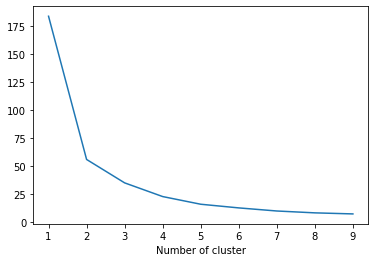

In [27]:
PrintKmeansInertiaGraphWithArray(sub,['scale_recency','scale_frequency','scale_revenue'])

In [28]:
PerformKMeansWithArray(sub, ['scale_recency','scale_frequency','scale_revenue'], 5, 'Seller_RFM_cluster')
sellers = sellers.merge(sub[['Seller_RFM_cluster','SellerID','Seller_Overall_RFM_Scaled']], on='SellerID')

sellers['Seller_OverallRFMScore'] = sellers['Seller_RecencyCluster'] + sellers['Seller_FrequencyCluster'] + sellers['Seller_RevenueCluster']
sellers['Seller_OverallRFM_Raw'] = sellers['Seller_Recency'] + sellers['Seller_Frequency'] + sellers['Seller_Revenue']
sellers.columns

Index(['SellerID', 'Seller_Recency', 'Seller_Frequency', 'Seller_Revenue',
       'Seller_RecencyCluster', 'Seller_FrequencyCluster',
       'Seller_RevenueCluster', 'Seller_RFM_cluster',
       'Seller_Overall_RFM_Scaled', 'Seller_OverallRFMScore',
       'Seller_OverallRFM_Raw'],
      dtype='object')

In [29]:
sellers = clustersInOrder('Seller_RFM_cluster', 'Seller_Overall_RFM_Scaled', sellers, True)

<h4>Alternative RFM Clustering, sum RFM for overall score</h4>

In [30]:
#calculate overall score and use mean() to see details
sellers['Seller_OverallRFMScore'] = sellers['Seller_RecencyCluster'] + sellers['Seller_FrequencyCluster'] + sellers['Seller_RevenueCluster']
print(sellers.groupby('Seller_OverallRFMScore')[['Seller_Recency','Seller_Frequency','Seller_Revenue']].mean())

print(sellers.groupby('Seller_OverallRFMScore')[['Seller_Revenue']].count())

                        Seller_Recency  Seller_Frequency  Seller_Revenue
Seller_OverallRFMScore                                                  
0                           525.327273          3.523636      739.880145
1                           318.578804          7.076087     1200.217310
2                           161.557613          8.923868     1680.105700
3                            33.479063         13.408801     2222.760114
4                            35.313514         58.091892    13024.190649
5                            22.739394        126.012121    19454.307455
6                            22.560976        232.658537    46439.367073
7                            14.851852        425.074074    53798.847037
8                            22.625000        638.875000   128986.017500
9                             7.375000       1187.125000   175086.316250
10                           10.600000       1252.600000   254983.110000
                        Seller_Revenue
Seller_Overa

In [31]:
sellers['Seller_RFM_Ranking'] = '0-Lowest'
sellers.loc[sellers['Seller_OverallRFMScore']>=1,'Seller_RFM_Ranking'] ='1-Low' 
sellers.loc[sellers['Seller_OverallRFMScore']>=4, 'Seller_RFM_Ranking'] = '2-Medium'
sellers.loc[sellers['Seller_OverallRFMScore']>=6, 'Seller_RFM_Ranking'] = '3-High'

<h4>Merge in RFM Clusters</h4>

In [32]:
OL_Data = OL_Data.merge(buyers, left_on='customer_unique_id', right_on='CustomerUniqueID')
OL_Data = OL_Data.merge(sellers, left_on='seller_id',right_on='SellerID')
OL_Data.columns

Index(['Unnamed: 0', 'order_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'shipping_limit_date', 'payment_installments',
       'product_category_name_english', 'seller_id', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'seller_latitude', 'seller_longitude',
       'customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'customer_latitude',
       'customer_longitude', 'review_id', 'review_score',
       'review_creation_date', 'review_answer_timestamp', 'Total_price',
       'number_of_items', 'Median_payments', 'Total_payment', 'Total_Freight',
       'order_weight_g', 'order_volume_cm3', 'payment_type',
       'Purchase_To_Delivery_Days', 'Approved_To_Delivery_Days',
       'Diff_Est_Delivery_vs_Actual', 'CustomerUniqueID', 'Buyer_Recency',
       'Buyer_RecencyCluster', 'Bu

<h3>Add Distance from Buyer to Seller</h3>

In [33]:
#calculate Distance Between Two Points on Earth
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lon1, lat2, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
     
     
OL_Data['DistanceOfSale'] = OL_Data.apply(lambda x: distance(x.customer_latitude, x.customer_longitude, x.seller_latitude, x.seller_longitude) , axis=1)

In [34]:
OL_Data['DistanceOfSale'].describe()

count    99727.000000
mean       603.487296
std        596.949713
min          0.000000
25%        189.670210
50%        435.533645
75%        801.451936
max       8736.947618
Name: DistanceOfSale, dtype: float64

<div class="span5 alert alert-info">
<h3>Write out data</h3>
</div>

In [35]:
OL_Data.to_csv('./OLData_RFM_Metrics.csv')

<div class="span5 alert alert-info">
<h3>Buyer Sub Clusters </h3>
</div>

['1-Low' '0-Lowest' '2-Medium' '3-High' '4-Highest']


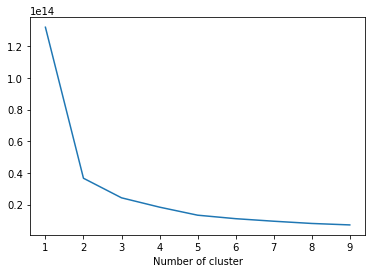

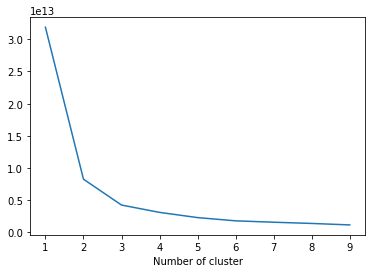

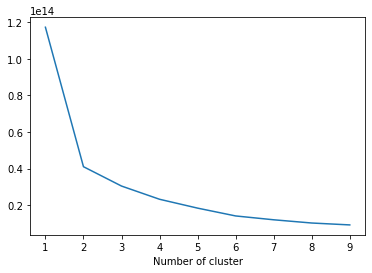

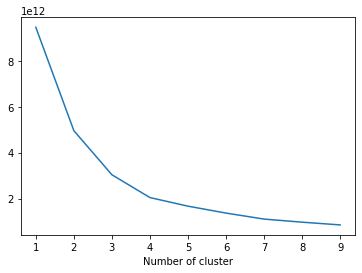

C:\Users\Karl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



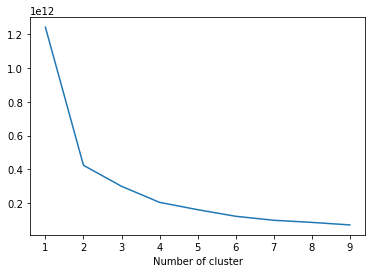

In [36]:
clusters={"1-Low":3,"0-Lowest":3,"2-Medium":2,"3-High":4,"4-Highest":4}

print(OL_Data['Buyer_RFM_Ranking'].unique())

OL_Data_Sub = OL_Data.copy()
subData = pd.DataFrame({'order_id' : [], 'Buyer_RFM_Ranking_SubClusers':[]})

for t in OL_Data['Buyer_RFM_Ranking'].unique():
    subset = OL_Data[OL_Data['Buyer_RFM_Ranking']==t]
    
    numcols = ['payment_installments',
            'seller_latitude', 
            'seller_longitude',
            'customer_latitude',
            'customer_longitude', 
            'review_score',
            'Total_price',
            'number_of_items', 
            'Median_payments', 
            'Total_payment', 
            'Total_Freight',
            'order_weight_g', 
            'order_volume_cm3', 
            'Purchase_To_Delivery_Days', 
            'Approved_To_Delivery_Days',
            'Diff_Est_Delivery_vs_Actual',
            'Buyer_OverallRFM_Raw',
            'Seller_OverallRFM_Raw', 
            'Seller_RFM_cluster',
            'DistanceOfSale']
    
    test = numcols+['order_id']
    subset = subset[test].dropna()
    
    
    PrintKmeansInertiaGraphWithArray(subset,numcols)
    PerformKMeansWithArray(subset, numcols, clusters[t], "Buyer_RFM_Ranking_SubClusers", t)
    subData = pd.concat([subData, subset[["order_id","Buyer_RFM_Ranking_SubClusers"]]], ignore_index=True)
    
OL_Data_Sub = OL_Data_Sub.merge(subData, on='order_id',how='left' )

<div class="span5 alert alert-info">
<h3>Seller Sub Clusters </h3>
</div>

['1-Low' '2-Medium' '3-High' '0-Lowest']


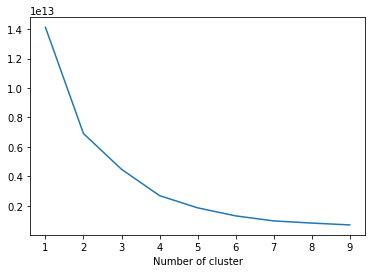

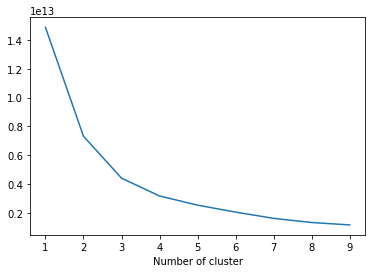

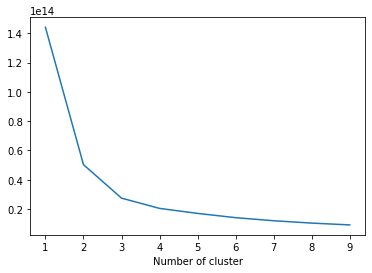

C:\Users\Karl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



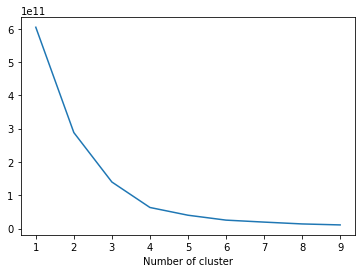

In [37]:
clusters={'1-Low':4, '2-Medium':4, '3-High':4, '0-Lowest':4}
print(OL_Data['Seller_RFM_Ranking'].unique())

subData = pd.DataFrame({'order_id' : [], 'Seller_RFM_Ranking_SubClusers':[]})
for t in OL_Data['Seller_RFM_Ranking'].unique():
    subset = OL_Data[OL_Data['Seller_RFM_Ranking']==t]
    
    numcols = ['payment_installments',
            'seller_latitude', 
            'seller_longitude',
            'customer_latitude',
            'customer_longitude', 
            'review_score',
            'Total_price',
            'number_of_items', 
            'Median_payments', 
            'Total_payment', 
            'Total_Freight',
            'order_weight_g', 
            'order_volume_cm3', 
            'Purchase_To_Delivery_Days', 
            'Approved_To_Delivery_Days',
            'Diff_Est_Delivery_vs_Actual',
            'Buyer_OverallRFM_Raw',
            'Seller_OverallRFM_Raw', 
            'Seller_RFM_cluster',
            'DistanceOfSale']
    
    test = numcols+['order_id']
    subset = subset[test].dropna()
    
    
    PrintKmeansInertiaGraphWithArray(subset,numcols)
    PerformKMeansWithArray(subset, numcols, clusters[t], "Seller_RFM_Ranking_SubClusers", t)
    subData = pd.concat([subData, subset[["order_id","Seller_RFM_Ranking_SubClusers"]]], ignore_index=True)

OL_Data_Sub = OL_Data_Sub.merge(subData, on='order_id',how='left' )


<h4>Write Out Data For Tableau</h4>

In [38]:
OL_Data_Sub[["order_id","Buyer_RFM_Ranking_SubClusers","Seller_RFM_Ranking_SubClusers"]].to_csv('./OLData_SubClusters.csv')

<div class="span5 alert alert-info">
<h3>Lines from Seller To Buyer </h3>
</div>

In [39]:

AllOrderLines = []
for index, row in OL_Data.iterrows():
    originRow = {}
    destRow = {}
    
    originRow['Origin-Destination'] = 'Origin'
    destRow['Origin-Destination'] = 'Destination'

    idName = "{0}-{1}".format(row['customer_id'],index)
    originRow['PathId'] = idName
    destRow['PathId'] = idName

    originRow['Latitude'] = row['seller_latitude']
    originRow['Longitude'] = row['seller_longitude']
    destRow['Latitude'] = row['customer_latitude']
    destRow['Longitude'] =  row['customer_longitude']
    
    originRow['Buyer_RFM_Ranking'] = row['Buyer_RFM_Ranking']
    destRow['Buyer_RFM_Ranking'] = row['Buyer_RFM_Ranking']    
    originRow['Seller_RFM_Ranking'] = row['Seller_RFM_Ranking']
    destRow['Seller_RFM_Ranking'] = row['Seller_RFM_Ranking']
    
    AllOrderLines.append(originRow)
    AllOrderLines.append(destRow)
    
mapDf = pd.DataFrame(AllOrderLines)
mapDf.to_csv('./OrderMapData.csv')